<a id="top"></a>
# <div style="padding:20px;color:white;margin:0;font-size:36px;font-family:Georgia;text-align:center;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>Deep Learning for Actuaries</b></div>

<div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:center;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>Three interpretable frameworks for an actuarial context</b></div>

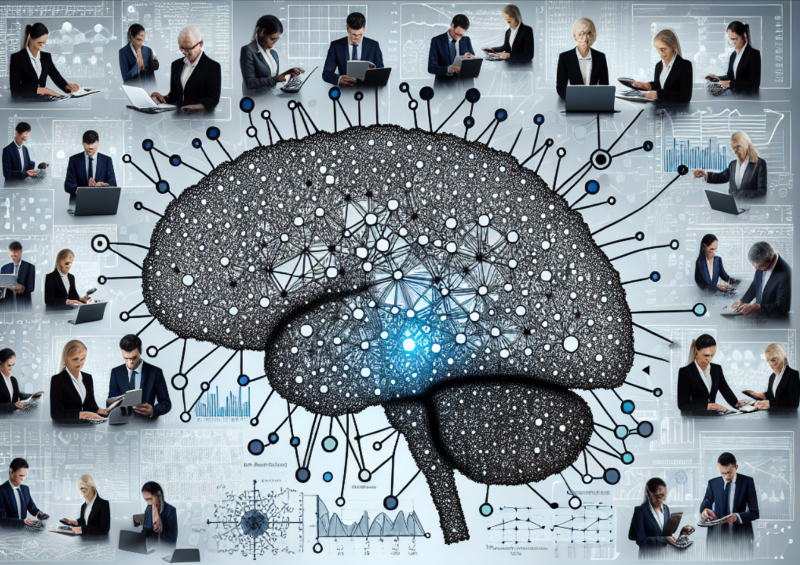  

<div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>Introduction</b></div>

<div style="text-align: justify;">Recent breakthroughs in artificial intelligence (AI) have been largely driven by neural networks, particularly deep learning frameworks. These techniques have revolutionized fields such as image recognition, natural language processing, and predictive analytics.
However, it can be difficult to apply neural networks in actuarial settings. First, neural networks are often considered "black boxes" because of their complex structure with thousands of parameters. Actuaries usually produce rating structures that clearly show how premiums and risk behave over different variables, as transparency and interpretability are crucial in actuarial work. Neural networks though only return a single prediction which makes it much more difficult to interpret model results and provide explanations to stakeholders. Second, most actuarial datasets have a tabular structure, consisting of structured numerical and categorical variables. It has been shown that neural networks and deep learning mainly excel in tasks such as image recognition and language processing <reference>. On tabular data, traditional models such as Generalized Linear Models (GLM) or tree-based models (e.g. Random Forest, GBM) usually perform better.
Recognizing these challenges, deep learning frameworks suited for actuarial problems and tabular data have been developed in the academic community. In this article, we discuss three of these frameworks: the Combined Actuarial Neural Network (CANN), LocalGLMNet and TabNet. We briefly explain the workings of these models and the pros and cons of each method.
</div>

<a id="top"></a>
# <div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>Table of Contents</b></div>

<div style="background-color:aliceblue; padding:30px; font-size:15px;color:#034914">
    
<a id="TOC"></a>
    
* [Code setup](#code_setup)
* [Import libraries and load data](#import)
* [Data Preprocessing](#data_preprocessing)
* [Model Evaluation Functions](#model_evaluation)
* [The GLM benchmark model](#glm)
* [The Combined Actuarial Neural Network](#cann)
* [LocalGLMNet](#localglm)
* [TabNet](#tabnet)
* [Results evaluation](#results)
* [References](#ref)
* [Related Projects](#rel)

<a id="code_setup"></a>
<div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>Code setup</b></div>

The python version used for this notebook is 3.10.x

We recommend to create a dedicated Conda environment for this notebook. See the example terminal commands:

Along with the python version, please install:

- Create a new conda environment named 'dl-env' with Python 3.10:
*conda create -n dl-env python=3.10*

- Activate the new environment:
*conda activate dl-env*

- Install the required packages:
*conda install pandas scikit-learn matplotlib numpy*

- Install TensorFlow using pip:
*pip install tensorflow*

- Install PyTorch and torchvision for CPU only:
*conda install pytorch torchvision torchaudio cpuonly -c pytorch*

- and all other remaining packages below

<a id="import"></a>
<div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>Import libraries and load data</b></div>

In [38]:
# Load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_poisson_deviance
from scipy.sparse import csr_matrix

import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.optimizers import Nadam

from torch import nn
import torch
import torch.autograd as autograd
from skorch import NeuralNetRegressor
from torch.optim import NAdam

from pytorch_tabnet.tab_model import TabNetRegressor

For simplicity and transparency, we use an open source dataset with a portfolio of car insurance policies and claims. The dataset can be loaded from the repository or it can be found on Kaggle (https://www.kaggle.com/datasets/floser/french-motor-claims-datasets-fremtpl2freq). This is a well-known and often used dataset for modelling. This provides transparency as results can be benchmarked to other work.

In [39]:
# Load the dataset (replace with your actual file path)
#data = pd.read_csv('C:/Users/R0626499/OneDrive - Allianz/Documents/Bart/Actuaris/DL_for_Actuaries/data/freMTPL2freq.csv')
data = pd.read_csv('C:/Users/bart_/Documents/git_repo/DL_for_Actuaries/data/freMTPL2freq.csv')

# Inspect the dataset
data.head()

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1,0.10,D,5,0,55,50,B12,Regular,1217,R82
1,3.0,1,0.77,D,5,0,55,50,B12,Regular,1217,R82
2,5.0,1,0.75,B,6,2,52,50,B12,Diesel,54,R22
3,10.0,1,0.09,B,7,0,46,50,B12,Diesel,76,R72
4,11.0,1,0.84,B,7,0,46,50,B12,Diesel,76,R72


In [40]:
data.shape

(678013, 12)

<a id="data_preprocessing"></a>
<div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>Data Preprocessing</b></div>

The preprocessing is largely based on Richman & Wüthrich (2023), meaning that data in the tails will be right-censored. Furthermore, the Area feature is encoded to be treated as a continuous feature.

The dataset consists of a mix of numerical and categorical features. Many machine learning models cannot process categorical features in their raw format, so we need to One-Hot encode the categorical features. Furthermore, it is common the standardize numerical data before training. Both the standardization and onehot encoding are applied below in a preprocessing pipeline. 

Another important step is the creation of a train and test sample, a 90/10 split will be used.

In [41]:
# Some data preparation
data['Exposure'] = 1 # Set exposure to 1 for simplicity
exposure = data['Exposure']

# Right-censor the data to deal with low observations
data['VehAge'] = data['VehAge'].clip(upper=20)
data['DrivAge'] = data['DrivAge'].clip(upper=90)
data['BonusMalus'] = data['BonusMalus'].clip(upper=150)

# Encode Area as continuous
area_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6}
data['Area'] = data['Area'].map(area_mapping)

# 5. Remove missing values
data = data.dropna()

# Preprocess the Dataset
numerical_features = ['VehPower', 'VehAge', 'DrivAge', 'BonusMalus','Area']
categorical_features = ['VehBrand', 'Region','VehGas']

y = data['ClaimNb']
X = data.drop(columns=['ClaimNb', 'Exposure', 'IDpol'], axis=1)

# Create a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# Split the dataset including the exposure
X_train, X_test, y_train, y_test, exposure_train, exposure_test = train_test_split(
    X, y, exposure, test_size=0.1, random_state=42
)

# Apply the preprocessing pipeline
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Get categorical feature names from OneHotEncoder
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features).tolist()

# Combine numerical and encoded categorical feature names
feature_names = numerical_features + cat_feature_names

<a id="model_evaluation"></a>
<div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>Model Evaluation Functions</b></div>

In this section we will define functions that will evaluate the model performance. As evaluation metrics we chose RMSE, mean absolute error (MAE) and Poisson deviance as they are commonly used for model performance assessment. Furthermore, we define functions for graphical evaluation with quantile plots (showing actuals vs predictions) and double lift charts for model comparison. 

In [42]:
# Dictionary to store evaluation results
model_results = {}

# Function to calculate model performance metrics and store them in a dict
def evaluate_model(model_name, y_true, y_pred):
    rmse = float(root_mean_squared_error(y_true, y_pred))  # Convert to float
    mae = float(mean_absolute_error(y_true, y_pred))  # Convert to float
    poisson_dev = float(mean_poisson_deviance(y_true, y_pred))  # Convert to float

    # Store results in the dictionary
    model_results[model_name] = {
        "RMSE": rmse,
        "MAE": mae,
        "Poisson Deviance": poisson_dev
    }

    print(f"{model_name} - RMSE: {rmse:.4f}, MAE: {mae:.4f}, Poisson Deviance: {poisson_dev:.4f}")


In [43]:
def quantile_plot(model_name,y_true, y_pred, num_bins=10):
    # Create a DataFrame with true and predicted values
    df = pd.DataFrame({'Actual': y_true, 'Predicted': y_pred})

    # Create groups
    df['Decile'] = pd.qcut(df['Predicted'], q=num_bins, labels=False)

    # Calculate average actual and predicted values for each decile
    decile_summary = df.groupby('Decile').agg({'Actual': 'mean', 'Predicted': 'mean'}).reset_index()

    plt.figure(figsize=(7, 4))
    plt.plot(decile_summary['Decile'], decile_summary['Actual'], marker='o', label='Actual')
    plt.plot(decile_summary['Decile'], decile_summary['Predicted'], marker='x', label='Predicted')
    plt.xlabel('Decile')
    plt.ylabel('Average Value')
    plt.title(f"Actual vs predicted: {model_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

In [44]:
def double_lift_chart(model_name1, model_name2, y_true, y_pred1, y_pred2, exposure, num_bins=10):
    # Create a DataFrame with actual, predicted values, and exposure
    df = pd.DataFrame({'Actual': y_true, 
                       'Predicted1': y_pred1, 
                       'Predicted2': y_pred2, 
                       'Exposure': exposure})
    
    # Compute ratio of model prediction 2 to model prediction 1
    df['Ratio'] = df['Predicted2'] / df['Predicted1']
    
    # Sort by the ratio
    df = df.sort_values(by='Ratio')

    # Compute cumulative exposure to create equal exposure bins
    df['Cumulative_Exposure'] = df['Exposure'].cumsum()
    total_exposure = df['Exposure'].sum()
    
    # Assign deciles based on equal exposure
    df['Decile'] = pd.cut(df['Cumulative_Exposure'], 
                          bins=np.linspace(0, total_exposure, num_bins+1), 
                          labels=False, 
                          include_lowest=True)

    # Aggregate by decile
    decile_summary = df.groupby('Decile').agg({'Actual': 'mean', 
                                               'Predicted1': 'mean', 
                                               'Predicted2': 'mean'}).reset_index()

    # Indexing: Divide by the overall mean
    decile_summary['Actual'] /= df['Actual'].mean()
    decile_summary['Predicted1'] /= df['Predicted1'].mean()
    decile_summary['Predicted2'] /= df['Predicted2'].mean()

    # Plot double lift chart
    plt.figure(figsize=(7, 4))
    plt.plot(decile_summary['Decile'], decile_summary['Actual'], marker='o', label='Actual', linestyle='-')
    plt.plot(decile_summary['Decile'], decile_summary['Predicted1'], marker='x', label=model_name1, linestyle='--')
    plt.plot(decile_summary['Decile'], decile_summary['Predicted2'], marker='s', label=model_name2, linestyle='-.')
    
    plt.xlabel('Decile (Sorted by Ratio of Model 2 to Model 1)')
    plt.ylabel('Indexed Value')
    plt.title(f"Double Lift Chart: {model_name1} vs {model_name2}")
    plt.legend()
    plt.grid(True)
    plt.show()

<a id="model_evaluation"></a>
<div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>The GLM benchmark model</b></div>

As a first step and benchmark we will now fit a GLM. As we are predicting claim frequency (count) we will use a Poisson distribution. For this we employ a PoissonRegressor from Scikit learn's linear model library. The only parameter that is defined in the Poisson Regressor is 'alpha', which indicates the regularization strength (the extent to which L2 penalty terms are applied). For this simple implementation we will go with traditional, unpenalized GLMs (alpha=0).  

In [45]:
# Instantiate the Poisson regressor
glm = PoissonRegressor(alpha=0)
glm.fit(X_train, y_train)

PoissonRegressor(alpha=0)

Now the GLM is fitted, we can inspect the features and coefficients:

In [46]:
# Get the coefficients from the model
coefficients = glm.coef_

# Display
coef_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coefficients})
coef_df["Abs_Coefficient"] = coef_df["Coefficient"].abs()
coef_df = coef_df.sort_values(by="Abs_Coefficient", ascending=False).drop(columns="Abs_Coefficient")
print(coef_df)

           Feature  Coefficient
19      Region_R23    -0.310495
28      Region_R53     0.291609
3       BonusMalus     0.280360
31      Region_R73    -0.235607
20      Region_R24     0.233436
34      Region_R83    -0.208539
21      Region_R25     0.200424
23      Region_R31    -0.185984
33      Region_R82     0.183471
2          DrivAge     0.179089
30      Region_R72    -0.166583
1           VehAge    -0.165366
32      Region_R74     0.150778
35      Region_R91    -0.134827
14     VehBrand_B5     0.112422
27      Region_R52     0.111502
29      Region_R54     0.098630
38   VehGas_Diesel    -0.091885
10    VehBrand_B14    -0.083858
6     VehBrand_B10    -0.069260
24      Region_R41    -0.065605
18      Region_R22     0.060355
8     VehBrand_B12    -0.056526
36      Region_R93    -0.053081
4             Area     0.049917
26      Region_R43    -0.048182
25      Region_R42     0.046580
22      Region_R26    -0.043340
15     VehBrand_B6    -0.035368
5      VehBrand_B1     0.030330
11     V

For evaluation, we first need to make predictions on our test sample. When predictions on X_test are available, we can call the evaluation function and plot the double lift chart:

In [47]:
# Get GLM predictions
glm_preds_train = glm.predict(X_train)
glm_preds_test = glm.predict(X_test)

In [48]:
# Evaluate GLM
evaluate_model("GLM", y_test, glm_preds_test)

GLM - RMSE: 0.2335, MAE: 0.0991, Poisson Deviance: 0.3080


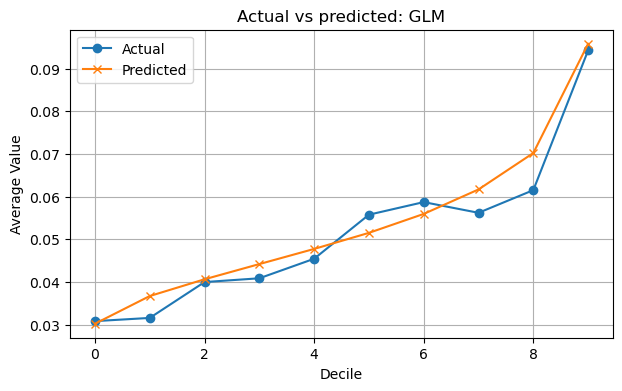

In [49]:
quantile_plot("GLM",y_test, glm_preds_test)

<a id="cann"></a>
<div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>The Combined Actuarial Neural Network</b></div>

**A brief intro to Neural Networks**

A neural network is a model inspired by the structure of the human brain. It consists of multiple layers of interconnected nodes (neurons) that process the data and aim to learn the relationships in the data. The three main components of a neural network are:

•	**Input layer**: This is the layer that processes the input data. Each neuron in this layer represents a feature in the dataset (e.g., policyholder age, claim history, insured amount). 

•	**Hidden layers**: The hidden layers perform complex transformations on the data. Each neuron in a hidden layer takes inputs from the previous layer, applies a transformation and weighting, and then passes the result through an activation function. 

•	**Output layer**: The output layer produces the final prediction for the problem at hand. 

Neural networks are usually trained ‘supervised’, meaning that we give the true labels of our problem to the model. So in a classification problem for example, we will provide the true labels which the model can compare to the predicted labels in a loss function. The neural network then learns by adjusting the weights of connections between the neurons to optimize the loss function. 

**The Combined Actuarial Neural Network (CANN)**

The CANN model, as proposed by Wüthrich & Merz (2019) combines a GLM with a neural network. By using the GLM predictions, the neural network part aims to capture additional patterns that were not captured by the GLM. In the output layer, the final CANN prediction is then obtained by combining the GLM prediction (that arrives via a ‘skip connection’) with the neural network prediction. In this way, CANN retains the interpretability of GLMs while improving predictive performance.

For example implementations of CANN, check:

- https://github.com/freekholvoet/nnforfreqsevpricing
- https://www.kaggle.com/code/floser/use-case-claim-frequency-modeling-python

In [50]:
# Define the GLM predictions for the Skip-layer of CANN
log_glm_preds_train = np.log(glm_preds_train)
log_glm_preds_test = np.log(glm_preds_test)

For the architecture of the neural network part, we will largely follow Wüthrich & Merz (2023). The input layer gets the number of neurons equal to the size of the feature set. Next, three hidden, fully-connected layers are added with ReLu activation. We also experimented with Tanh activation but this did not change results significantly. 

Next the skip connection is added, so that the original GLM predictions arrive in the output layer, jointly with the neural network predictions. The output layer will then produce the final prediction through exponential activation.

Model parameters, such as the number of layers, layer-size, learning rate and batch-size can potentially be tuned, but for simplicity we will continue without hyperparameter tuning. We will now define the architecture of the model:

In [51]:
# Define Input Layer
input_layer = Input(shape=(X_train.shape[1],), name="Design")

# Neural Network layers
hidden1 = layers.Dense(128, activation="relu", name="hidden1")(input_layer)
hidden2 = layers.Dense(64, activation="relu", name="hidden2")(hidden1)
hidden3 = layers.Dense(32, activation="relu", name="hidden3")(hidden2)
nn_output = layers.Dense(1, activation=None, name="Network")(hidden3)

# GLM Skip connection
glm_input = Input(shape=(1,), name="LogGLM")

# Combine GLM and Neural Network Outputs
combined_output = layers.Add(name="Add")([nn_output, glm_input])

# Final Output Layer with exponential activation
final_output = layers.Dense(1, activation="exponential", name="Response")(combined_output)

# Create the model
cann_model = Model(inputs=[input_layer, glm_input], outputs=final_output)
cann_model.get_layer("Response").trainable = False
optimizer = Nadam(learning_rate=0.005)
cann_model.compile(optimizer=optimizer, loss="poisson")
cann_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Design (InputLayer) │ (None, 40)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden1 (Dense)     │ (None, 128)       │      5,248 │ Design[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden2 (Dense)     │ (None, 64)        │      8,256 │ hidden1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden3 (Dense)     │ (None, 32)        │      2,080 │ hidden2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Network (Dense)     │ (None, 1)         │         33 │ hidden3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LogGLM (InputLayer) │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Add (Add)           │ (None, 1)         │          0 │ Network[0][0],    │
│                     │                   │            │ LogGLM[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Response (Dense)    │ (None, 1)         │          2 │ Add[0][0]         │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 15,619 (61.01 KB)

 Trainable params: 15,617 (61.00 KB)

 Non-trainable params: 2 (8.00 B)

After defining the model we can train the model below. Many studies train with hundreds of epochs, from the plot below we have concluded that 15-20 epochs are enough for optimal results. More epochs result in overfitting.

In [52]:
# Train the CANN model
history_cann = cann_model.fit(
    [X_train, log_glm_preds_train],
    y_train,
    epochs=15,
    batch_size=4000,
    validation_data=([X_test, log_glm_preds_test], y_test)
)

Epoch 1/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.6741 - val_loss: 0.2028
Epoch 2/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2079 - val_loss: 0.2014
Epoch 3/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2070 - val_loss: 0.2007
Epoch 4/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2060 - val_loss: 0.2006
Epoch 5/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2064 - val_loss: 0.2005
Epoch 6/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2059 - val_loss: 0.2000
Epoch 7/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2046 - val_loss: 0.2002
Epoch 8/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2043 - val_loss: 0.1999
Epoch 9/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2042 - val_loss: 0.1993
Epoch 10/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2038 - val_loss: 0.2007
Epoch 11/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2048 - val_loss: 0.1991
Epoch 12/15
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/ste

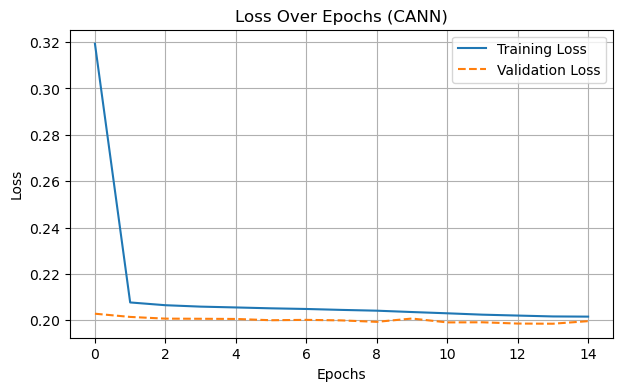

In [53]:
# Plot the loss over the epochs
plt.figure(figsize=(7, 4))
plt.plot(history_cann.history['loss'], label='Training Loss')
plt.plot(history_cann.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Loss Over Epochs (CANN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Let us now evaluate the performance of the CANN model. We can print model metrics and compare predictions vs actuals:

In [54]:
# Evaluate CANN
cann_preds_test = cann_model.predict([X_test, log_glm_preds_test])
cann_preds_test = np.maximum(cann_preds_test, 1e-6)  
evaluate_model("CANN", y_test, cann_preds_test)

2119/2119 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
CANN - RMSE: 0.2331, MAE: 0.1066, Poisson Deviance: 0.3041


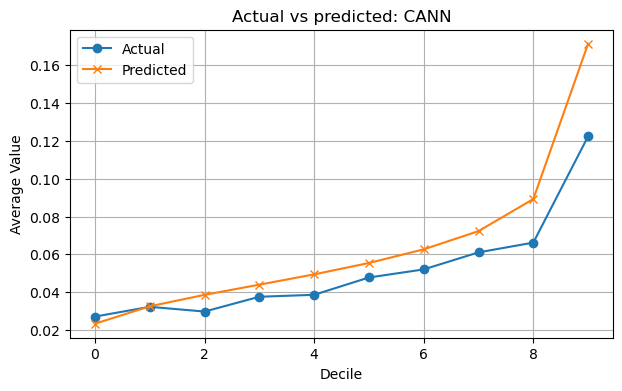

In [55]:
cann_preds_test_adj = np.ravel(cann_preds_test) 
quantile_plot("CANN",y_test, cann_preds_test_adj)

Now also compare the CANN predictions to the GLM predictions, by calling the double lift chart function:

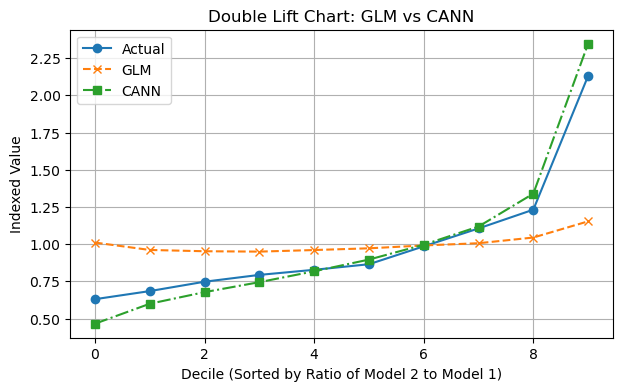

In [56]:
double_lift_chart("GLM", "CANN", y_test, glm_preds_test, cann_preds_test_adj, exposure_test, num_bins=10)

Now let's get some more insight into the differences in prediction. For this, we need to inverse the transformations done in the preproccesing step, to obtain a test set with original features. This enhances readability. 

Next, we can plot the predictions of the GLM and CANN per feature to assess how predictions vary and what is essentially the adjustment done by the neural network.

In [57]:
# Inverse transform the scaled data
scaler = preprocessor.named_transformers_['num']
X_test_dense = X_test.toarray() if isinstance(X_test, csr_matrix) else X_test
X_test_inv_scaled = scaler.inverse_transform(X_test_dense[:, :len(numerical_features)])

# Reversing the OneHotEncoder
encoder = preprocessor.named_transformers_['cat']
cat_feature_names = encoder.get_feature_names_out(categorical_features)
X_test_inv_categorized = encoder.inverse_transform(X_test_dense[:, len(numerical_features):])

# Combine the numerical and categorical back to a dataframe
X_test_inv = np.hstack([X_test_inv_scaled, X_test_inv_categorized])
X_test_inv_df = pd.DataFrame(X_test_inv, columns=numerical_features + categorical_features)

# Add predictions to the dataframe
X_test_inv_df['GLM_Predictions'] = glm_preds_test.ravel()
X_test_inv_df['CANN_Predictions'] = cann_preds_test.ravel()

In [79]:
def plot_feature_comparisons(features, X_test_inv_df, model1_preds, model2_preds, model1_label="Model 1", model2_label="Model 2"):
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    for i, feature_name in enumerate(features):
        plot_data = X_test_inv_df.groupby(feature_name)[[model1_preds, model2_preds]].mean().reset_index()
        
        ax = axes[i]
        ax.plot(plot_data[feature_name], plot_data[model1_preds], label=model1_label, linestyle="--", marker="o")
        ax.plot(plot_data[feature_name], plot_data[model2_preds], label=model2_label, linestyle="-", marker="s")
        
        # Fill the area between the two model predictions
        ax.fill_between(plot_data[feature_name], plot_data[model1_preds], plot_data[model2_preds],
                        color="salmon", alpha=0.5, label="NN adjustment")
        
        ax.set_xlabel(feature_name)
        ax.set_ylabel("Average Predicted Values")
        ax.set_title(f"{model1_label} and {model2_label} Predictions by {feature_name}")
        ax.grid(True)
        ax.legend()
    
    plt.tight_layout()
    plt.show()

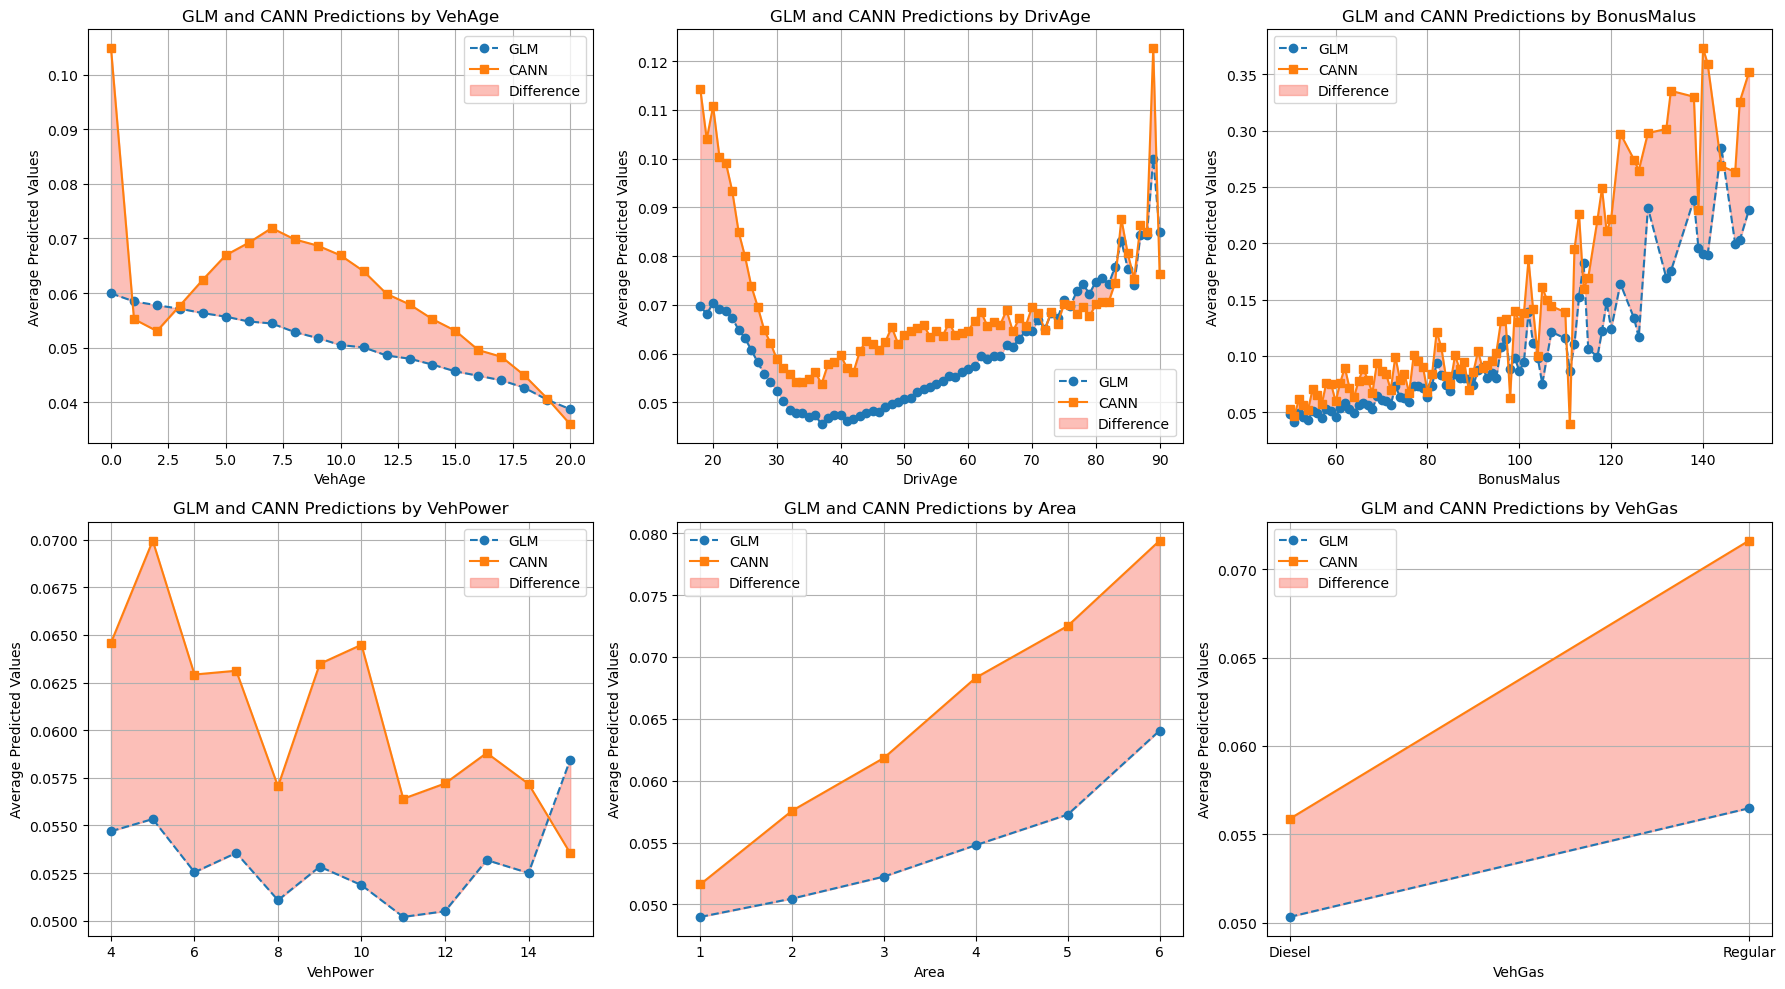

In [80]:
plot_feature_comparisons(['VehAge', 'DrivAge', 'BonusMalus', 'VehPower', 'Area', 'VehGas'], X_test_inv_df, 'GLM_Predictions', 'CANN_Predictions', model1_label="GLM", model2_label="CANN")

<a id="localglm"></a>
<div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>LocalGLMNet</b></div>

LocalGLM Net explanation

For the architecture of the neural network part, we will largely follow Richman & Wüthrich (2023). The input layer gets the number of neurons equal to the size of the feature set. Next, three hidden, fully-connected layers are added with hyperbolic tangent (Tanh) activation. These are followed by another layer with size equal to the size of the feature set. This layer aims to provide the attention weights of the network. In a neural network training, attention weights determine the importance of different parts of the input data. They basically help the model in focusing on the most relevant elements. In the LocalGLMNet framework, these attention weights are then multiplied with the input features to get to the final predictions.

Model parameters, such as the number of layers, layer-size, learning rate and batch-size can potentially be tuned, but for simplicity we will continue without hyperparameter tuning. We will now define the architecture of the model:

For example implementations of LocalGLMNet, check:

- https://www.kaggle.com/code/orereisrael/the-state-of-ai-tabular-time-series-data
- https://github.com/neeland/local-glm-net/tree/main/local-glm-net

In [60]:
# Define Input Layer
input_layer = Input(shape=(X_train.shape[1],), dtype='float32', name='Design')
exposure = Input(shape=(1,), dtype='float32', name='Exposure')

# Neural Network Layers (Attention Mechanism)
hidden1 = layers.Dense(20, activation='tanh', name='FNLayer1')(input_layer)
hidden2 = layers.Dense(15, activation='tanh', name='FNLayer2')(hidden1)
hidden3 = layers.Dense(10, activation='tanh', name='FNLayer3')(hidden2)
attention = layers.Dense(X_train.shape[1], activation='linear', name='Attention')(hidden3)

# Skip Connection: Element-wise multiplication of input_layer and attention
skip_connection = layers.Multiply(name='SkipConnection')([input_layer, attention])

# Sum along the feature dimension (axis=1) to get a single value per sample
localglm = layers.Lambda(lambda x: tf.reduce_sum(x, axis=1, keepdims=True), name='LocalGLM')(skip_connection)

# Apply final transformation
balance = layers.Dense(1, activation='exponential', name='Balance')(localglm)

# Final Response Calculation (Multiply with Exposure)
final_output = layers.Multiply(name='Multiply')([balance, exposure])

# Create and compile model
localglm_model = Model(inputs=[input_layer, exposure], outputs=[final_output], name='LocalGLMNet')
optimizer = Nadam(learning_rate=0.005)
localglm_model.compile(optimizer=optimizer, loss="poisson")
localglm_model.summary()

Model: "LocalGLMNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Design (InputLayer) │ (None, 40)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FNLayer1 (Dense)    │ (None, 20)        │        820 │ Design[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FNLayer2 (Dense)    │ (None, 15)        │        315 │ FNLayer1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FNLayer3 (Dense)    │ (None, 10)        │        160 │ FNLayer2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Attention (Dense)   │ (None, 40)        │        440 │ FNLayer3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ SkipConnection      │ (None, 40)        │          0 │ Design[0][0],     │
│ (Multiply)          │                   │            │ Attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LocalGLM (Lambda)   │ (None, 1)         │          0 │ SkipConnection[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Balance (Dense)     │ (None, 1)         │          2 │ LocalGLM[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Exposure            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Multiply (Multiply) │ (None, 1)         │          0 │ Balance[0][0],    │
│                     │                   │            │ Exposure[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,737 (6.79 KB)

 Trainable params: 1,737 (6.79 KB)

 Non-trainable params: 0 (0.00 B)

In [61]:
# Train the LocalGLM model
history_localglm = localglm_model.fit(
    [X_train, np.ones_like(y_train)], 
    y_train, 
    epochs=20, 
    batch_size=4000,
    validation_data=([X_test, np.ones_like(y_test)], y_test))

Epoch 1/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.4918 - val_loss: 0.2061
Epoch 2/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2095 - val_loss: 0.2023
Epoch 3/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2071 - val_loss: 0.2014
Epoch 4/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2067 - val_loss: 0.2010
Epoch 5/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2054 - val_loss: 0.2006
Epoch 6/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2061 - val_loss: 0.2004
Epoch 7/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2038 - val_loss: 0.2002
Epoch 8/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2060 - val_loss: 0.1999
Epoch 9/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2051 - val_loss: 0.1999
Epoch 10/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2046 - val_loss: 0.1995
Epoch 11/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2028 - val_loss: 0.1994
Epoch 12/20
153/153 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

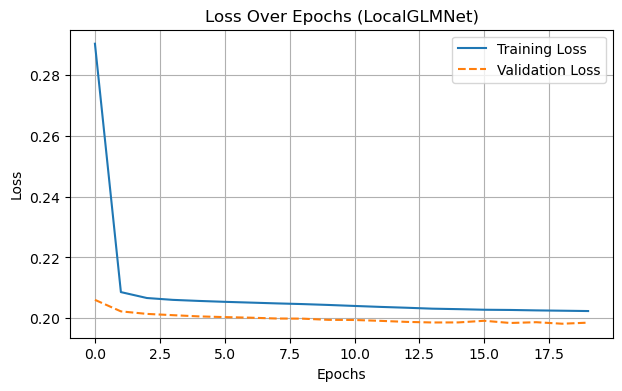

In [62]:
# Plot the loss over the epochs
plt.figure(figsize=(7, 4))
plt.plot(history_localglm.history['loss'], label='Training Loss')
plt.plot(history_localglm.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Loss Over Epochs (LocalGLMNet)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

The LocalGLMNet is trained, so we can evaluate the performance by calling the evaluation and plot functions:

In [63]:
# Evaluate LocalGLM
localglm_preds_test = localglm_model.predict([X_test, np.ones_like(y_test)])
evaluate_model("LocalGLMNet", y_test, localglm_preds_test)

2119/2119 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
LocalGLMNet - RMSE: 0.2328, MAE: 0.0978, Poisson Deviance: 0.3020


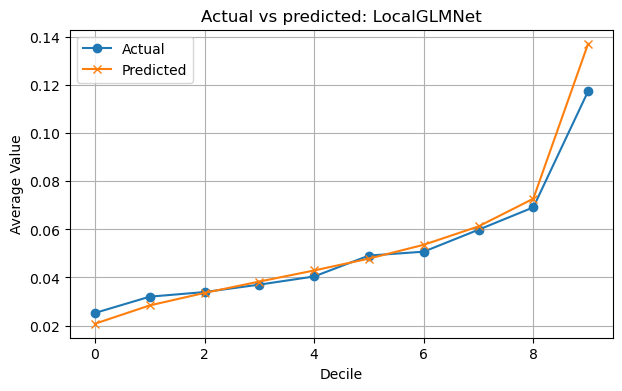

In [64]:
localglm_preds_test = np.ravel(localglm_preds_test) 
quantile_plot("LocalGLMNet",y_test, localglm_preds_test)

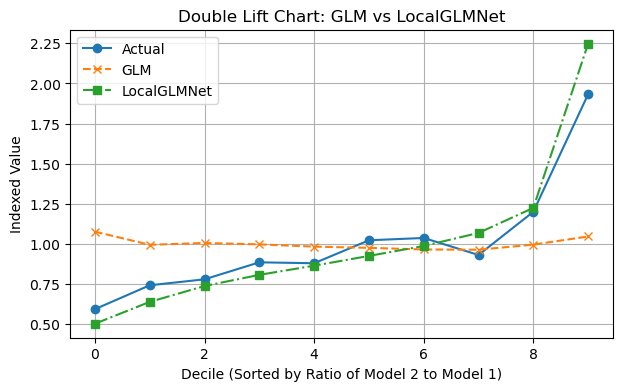

In [65]:
double_lift_chart("GLM", "LocalGLMNet", y_test, glm_preds_test, localglm_preds_test, exposure_test, num_bins=10)

*Alternative implementation of LocalGLM with Pytorch (@Garry I think the Keras implementation above is better)*

In [66]:
# # Build the LocalGLMNet Model
# class LocalGLMNet(nn.Module):
#     def __init__(self, input_size, hidden_layer_sizes):
#         super(LocalGLMNet, self).__init__()
#         self.hidden_layers = nn.ModuleList(
#             [nn.Linear(input_size, hidden_layer_sizes[0])]
#         )
#         self.hidden_layers.extend(
#             [
#                 nn.Linear(hidden_layer_sizes[i], hidden_layer_sizes[i + 1])
#                 for i in range(len(hidden_layer_sizes) - 1)
#             ]
#         )
#         self.last_hidden_layer = nn.Linear(hidden_layer_sizes[-1], input_size)
#         self.output_layer = nn.Linear(1, 1)
#         self.activation = nn.Tanh()
#         self.inverse_link = torch.exp

#     def forward(self, features, exposure=None, attentions=False):
#         x = features
#         for layer in self.hidden_layers:
#             x = self.activation(layer(x))
#         x = self.last_hidden_layer(x)
#         if attentions:
#             return x
#         skip_connection = torch.einsum("ij,ij->i", x, features).unsqueeze(1)
#         x = self.output_layer(skip_connection)
#         x = self.inverse_link(x)
#         if exposure is None:
#             exposure = torch.ones_like(x, device=features.device)
#         x = x * exposure
#         return x

# def train_model(X, v, y, device):
#     localglmnet = NeuralNetRegressor(
#         module=LocalGLMNet,
#         max_epochs=20,
#         criterion=nn.PoissonNLLLoss,
#         criterion__log_input=False,
#         module__input_size=X.shape[1],
#         module__hidden_layer_sizes=[128, 64, 32],
#         optimizer=NAdam,
#         lr=0.005,
#         batch_size=4000,
#         device=device,
#     )

#     X_dict = {"features": X, "exposure": v}
#     localglmnet.fit(X_dict, y)
#     return localglmnet

# def extract_contributions_and_gradients(localglmnet, X_val_torch, v_val_torch):

#     # Move the model to CPU
#     localglmnet_module = localglmnet.module_.to("cpu")

#     # Ensure the input tensors are on the CPU
#     X_val_torch = X_val_torch.to("cpu")
#     v_val_torch = v_val_torch.to("cpu")

#     # Get attentions from the PyTorch module forward method by passing attentions=True
#     with torch.no_grad():
#         unscaled_attentions = localglmnet_module(X_val_torch, exposure=v_val_torch, attentions=True).numpy()

#     # Get the scaling factor from the output layer
#     scaling = localglmnet_module.output_layer.weight.detach().numpy()

#     # Calculate attentions
#     attentions = unscaled_attentions * scaling

#     # Convert X_val_torch to a NumPy array for multiplication
#     X_val = X_val_torch.numpy()

#     # Calculate contributions by multiplying attentions with their corresponding feature values
#     contributions = np.multiply(attentions, X_val)

#     print("attentions shape: ", attentions.shape)

#     # Extracting the gradients
#     input_tensor = X_val_torch.clone().detach().requires_grad_(True)
#     attentions_tensor = localglmnet_module(input_tensor, exposure=v_val_torch, attentions=True)

#     n, p = input_tensor.shape
#     gradients = np.empty((p, n, p))
#     for i in range(p):
#         grad_scaling = torch.ones_like(attentions_tensor[:, i])
#         gradient_i = autograd.grad(
#             attentions_tensor[:, i], input_tensor, grad_scaling, create_graph=True
#         )
#         gradients[i, :, :] = gradient_i[0].detach().numpy() * scaling

#     return attentions, contributions, gradients

In [67]:
# Convert data to PyTorch tensors
# X_train_torch = torch.FloatTensor(X_train.toarray())
# y_train_torch = torch.FloatTensor(y_train.values)
# X_test_torch = torch.FloatTensor(X_test.toarray())
# y_test_torch = torch.FloatTensor(y_test.values)

In [68]:
# Train the LocalGLMNet
#trained_model = train_model(X_train_torch, np.ones_like(y_train_torch), y_train_torch, device='cpu')

In [69]:
# # Evaluate LocalGLMNet
# localglmnet_preds_test = trained_model.predict(X_test_torch)
# evaluate_model("LocalGLMNet", y_test, localglmnet_preds_test)

In [70]:
# # Example usage (assuming you have a trained model and validation data):
# v_val_torch = torch.ones_like(y_test_torch)  # Assuming y_test_torch is a PyTorch tensor

# attentions, contributions, gradients = extract_contributions_and_gradients(trained_model, X_test_torch, v_val_torch)

A new element of LocalGLMNet compared to CANN are the attention weights. As the attention weights help the neural network to focus on the most important elements, they can be used to inspect variable or feature importance. A common approach is to determine variable importance by aggregating absolute attention weights per feature and then calculating the mean.  

In [71]:
# Extract attention layer weights
attention_layer = localglm_model.get_layer("Attention")
attention_weights = attention_layer.get_weights()[0]

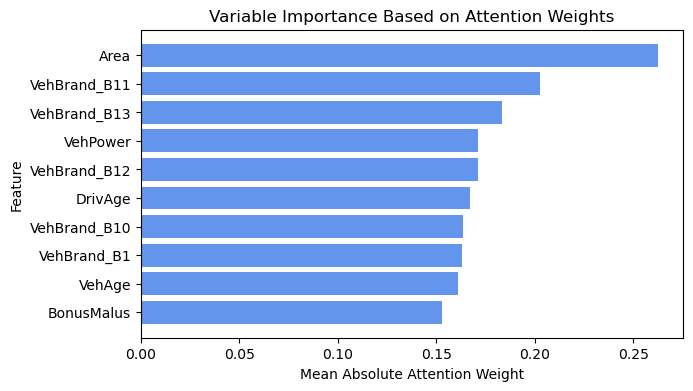

In [76]:
# Compute importance: Mean absolute weight across all neurons in the attention layer
feature_importance = np.mean(np.abs(attention_weights), axis=1)

sorted_idx = np.argsort(feature_importance)[::-1] 
    
plt.figure(figsize=(7, 4))
plt.barh(np.array(feature_names)[sorted_idx], feature_importance[sorted_idx], color="cornflowerblue")
plt.xlabel("Mean Absolute Attention Weight")
plt.ylabel("Feature")
plt.title("Variable Importance Based on Attention Weights")
plt.gca().invert_yaxis()  # Invert y-axis to show highest importance on top
plt.show()

Finally, as we showed for the CANN model, we can assess predictions of the LocalGLMNet versus the benchmark GLM for each feature.

In [77]:
# We have defined a proper X_test for the CANN model, so now we only need to add the LocalGLMNet predictions
X_test_inv_df['LocalGLM_Predictions'] = localglm_preds_test

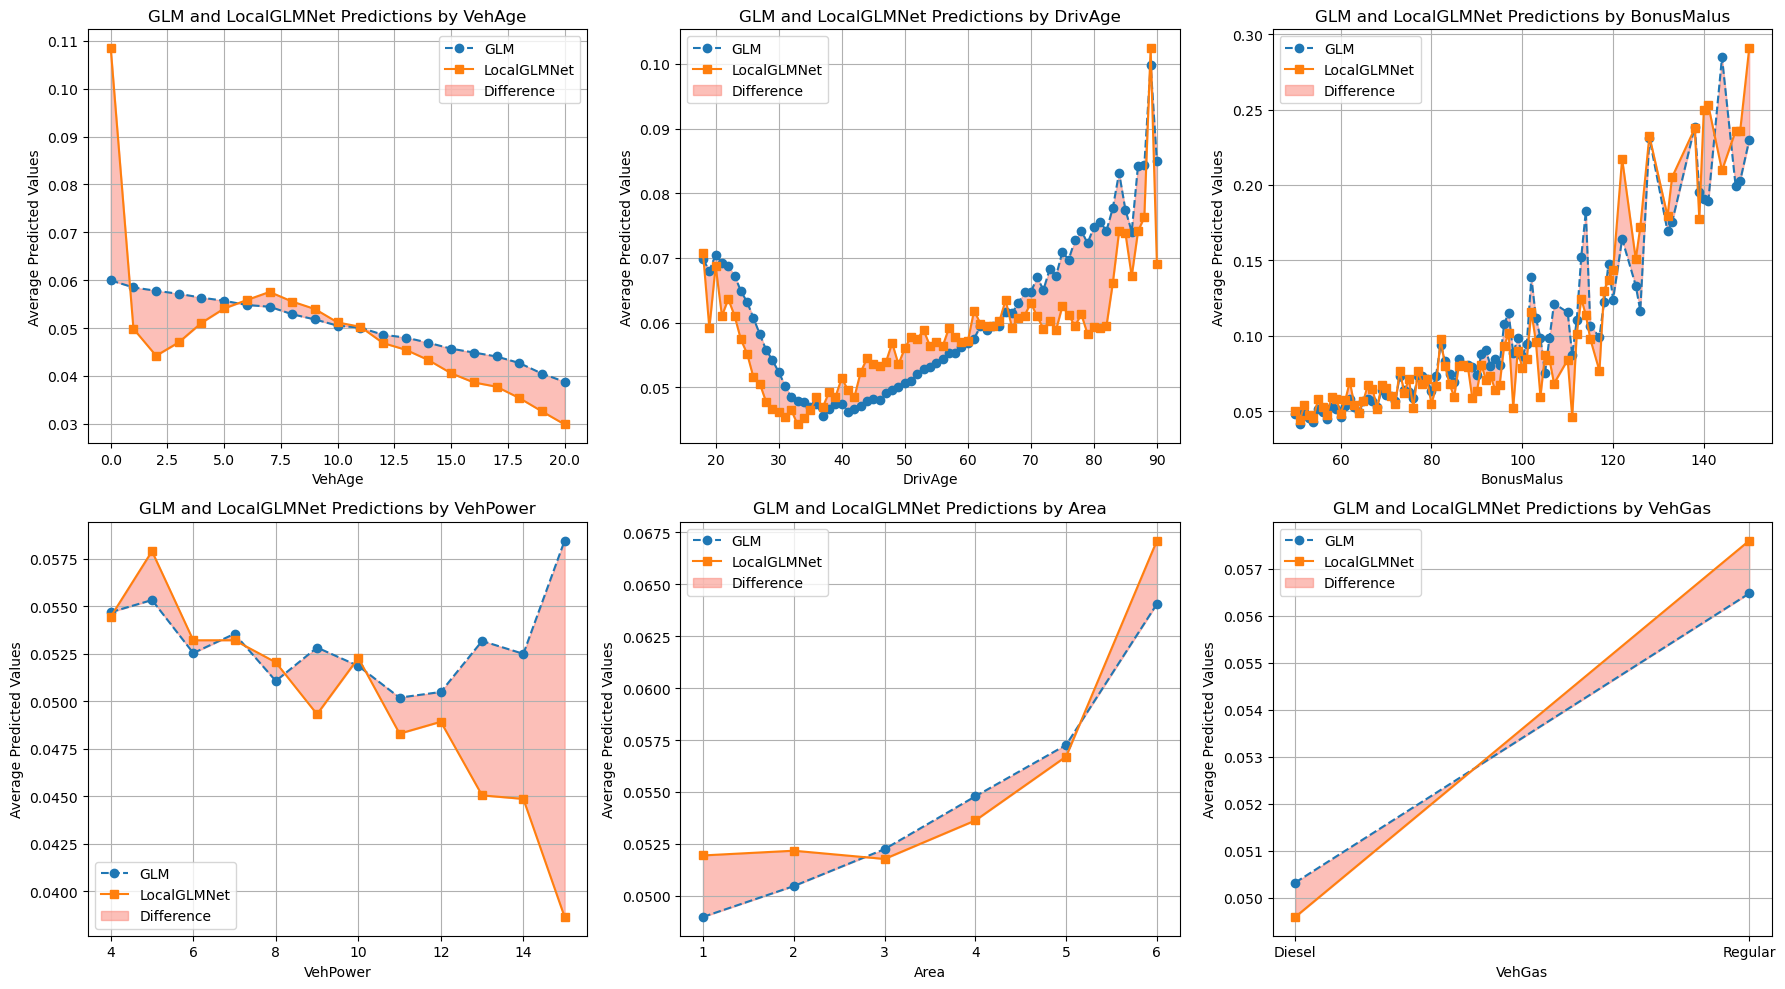

In [81]:
plot_feature_comparisons(['VehAge', 'DrivAge', 'BonusMalus', 'VehPower', 'Area', 'VehGas'], X_test_inv_df, 'GLM_Predictions', 'LocalGLM_Predictions', model1_label="GLM", model2_label="LocalGLMNet")

<a id="tabnet"></a>
<div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>TabNet</b></div>

For example implementations of TabNet, check:

- https://www.kaggle.com/code/wangqihanginthesky/baseline-tabnet

In [ ]:
# Step 7: Build the TabNet Model
# Initialize and train the TabNet model
tabnet = TabNetRegressor()

y_train_normalized = (y_train / exposure_train).values.reshape(-1, 1)
y_test_normalized = (y_test / exposure_test).values.reshape(-1, 1)

# Train the TabNet model with normalized targets
tabnet.fit(X_train, y_train_normalized,
           eval_set=[(X_test, y_test_normalized)],
           eval_metric=['rmse'],
           max_epochs=10)

# Evaluate TabNet
tabnet_preds_test_normalized = tabnet.predict(X_test)
tabnet_preds_test = tabnet_preds_test_normalized * exposure_test
evaluate_model("TabNet", y_test, tabnet_preds_test)

<a id="results"></a>
<div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>Results evaluation</b></div>

In [ ]:
# tbd

<a id="ref"></a>
<div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>References</b></div>

* Ronald Richman and Mario V. Wüthrich. 2023. LocalGLMnet: interpretable deep learning for tabular data. *Scandinavian Actuarial Journal* 2023(1), 71–95.

* Mario V. Wüthrich and Michael Merz. 2019. EDITORIAL: YES, WE CANN! *ASTIN Bulletin* 49(1), 1-3.

* Mario V. Wüthrich and Michael Merz. 2023. Statistical Foundations of Actuarial Learning and its Applications. Springer (open access), https://link.springer.com/book/10.1007/978-3-031-12409-9


<a id="rel"></a>
<div style="padding:20px;color:white;margin:0;font-size:24px;font-family:Georgia;text-align:left;display:fill;border-radius:5px;background-color:darkblue;overflow:hidden"><b>Related Projects</b></div>